# P-value – Simulation Demo
In this notebook, we simulate a coin flip experiment to demonstrate what statistical tests do and what p-value represents. We then explain the problem of multiple comparisons and a trivial solution.

## 1. 🪙 Example: Is This Coin Fair?
We flip a coin 100 times. If it’s fair, we expect ~50 heads. But what if we get 60? Is that unusual? Is the coin biased?

Let's assume we have an actually fair coin, we will answer the question with the following approach:

This demo lets you:

Simulate flipping a fair coin.

Compare the number of heads to the expected value.

See how rare your result is under the null hypothesis (i.e., the coin is fair).

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact, IntSlider
from IPython.display import Markdown

sns.set(style="whitegrid")
np.random.seed(42)

## 2. Simulate coin toss

In [31]:
def coin_p_value(num_flips=100, observed_heads=60, num_experiments=10000):
    # Simulate fair coin flips without binomial
    flips = np.random.rand(num_experiments, num_flips) < 0.5
    simulations = flips.sum(axis=1)

    expected = num_flips / 2
    diff = np.abs(observed_heads - expected)
    extreme_mask = np.abs(simulations - expected) >= diff
    p_val = np.mean(extreme_mask)

    # Plot
    plt.figure(figsize=(10, 5))
    bins = np.arange(0, num_flips+2) - 0.5
    sns.histplot(simulations, bins=bins, color='lightgray', label='Simulated # of Heads')
    plt.hist(simulations[extreme_mask], bins=bins, color='tomato', label='Extreme (p-value)', alpha=0.6)
    plt.axvline(observed_heads, color='red', linestyle='--', label=f'Observed = {observed_heads}')
    plt.axvline(expected, color='black', linestyle='-', label=f'Expected = {expected:.0f}')
    plt.title(f"Is the Coin Fair?  Empirical p-value = {p_val:.4f}")
    plt.xlabel("Number of Heads")
    plt.ylabel("Frequency")
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f"Observed heads: {observed_heads} out of {num_flips}")
    print(f"Empirical p-value (two-sided): {p_val:.4f}")

In [32]:
interact(
    coin_p_value,
    num_flips=IntSlider(value=100, min=10, max=200, step=10, description='# Flips'),
    observed_heads=IntSlider(value=60, min=0, max=200, step=1, description='Heads'),
    num_experiments=IntSlider(value=10000, min=10, max=50000, step=500, description='# Simulations'),
);

interactive(children=(IntSlider(value=100, description='# Flips', max=200, min=10, step=10), IntSlider(value=6…

## 3. Interpretation

- The shaded red bars show the part of the distribution more **extreme** than your observation.
- The **p-value** tells you how often you'd expect to see something this extreme if the coin was fair.

> A small p-value means your result is rare under the assumption of fairness.

> We did simulations to create the number of simulations (non-parametric test), however often parametrized distributions are assumed and parameters are estimated based on the observations (e.g. t-test, ...)

## 4. 🧪 Example: "Are any of these 50 coins unfair?" (Multiple comparisons problem)
Suppose you test 20 different coins.

Each one is actually fair.

- You flip each coin n times (say, 100), and record the number of heads.

- You check which ones give “significant” results (e.g. p < 0.05).

- Even though all coins are fair, some may appear significant by chance.



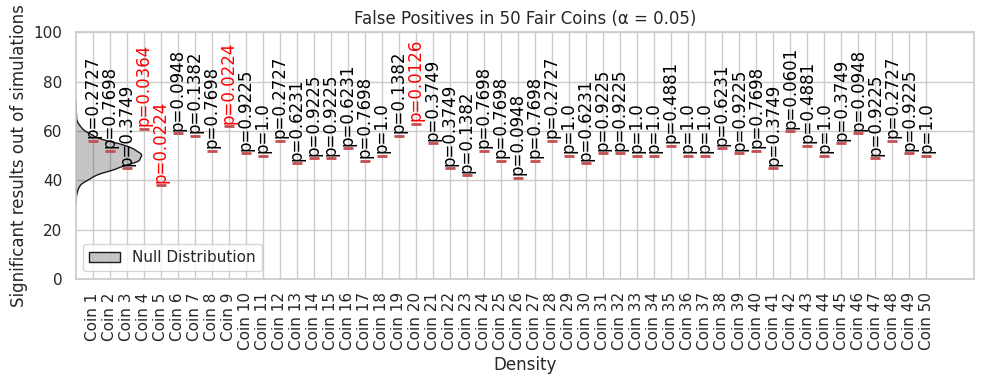

Total false positives (p < 0.05): 4 out of 50


In [124]:
def simulate_multiple_comparisons(num_coins=50, num_flips=100, alpha=0.05, num_experiments=10000):
    np.random.seed(2)
    # Simulate fair flips for each coin, shape = (num_coins, num_flips)
    flips = np.random.rand(num_coins, num_flips) < 0.5
    heads = flips.sum(axis=1)  # shape: (num_coins,)

    # Simulate null hypothesis
    simulations = np.random.binomial(num_flips, 0.5, size=num_experiments)

    expected = num_flips / 2
    diffs = np.abs(heads - expected)

    extreme_mask = np.abs(np.tile(simulations, (num_coins,1)) - expected) - diffs.reshape((-1,1)) >= 0
    p_vals = np.mean(extreme_mask, axis=1)

    # p < alpha if extreme beyond threshold
    significant_counts = np.sum(p_vals <= alpha)

    # Plot how many heads we got per coin
    fig, ax = plt.subplots(figsize=(10, 4))

    sns.kdeplot(y=simulations, ax=ax, fill=True, color='k',label='Null Distribution')

    # Just top edge
    for i, val in enumerate(heads):
        ax.hlines(y=val, xmin=(i+0.7)/num_coins, xmax=(i+1.3)/num_coins, color='r', linewidth=2, linestyles='--')
        ax.text(x = (i+1)/num_coins, y=val+1, s=f'p={p_vals[i]}', rotation=90, verticalalignment='bottom', horizontalalignment='center',
                color='red' if p_vals[i] <= alpha else 'black')

    ax.set_xticks(np.arange(1, num_coins+1)/num_coins)
    ax.set_xticklabels([f'Coin {i+1}' for i in range(num_coins)], rotation=90)
    plt.ylabel("Significant results out of simulations")
    plt.title(f"False Positives in {num_coins} Fair Coins (α = {alpha})")
    plt.legend()
    plt.ylim(0, num_flips)
    plt.tight_layout()
    plt.show()

    total_false_positives = np.sum(significant_counts)
    print(f"Total false positives (p < {alpha}): {total_false_positives} out of {num_coins}")

simulate_multiple_comparisons()

## 5. Bonferroni Correction

When performing multiple statistical tests, the chance of observing a false positive (a p-value < 0.05 by pure chance) increases with each additional test.

The **Bonferroni correction** helps control this by adjusting the threshold for significance:

$$
\alpha_{\text{corrected}} = \frac{\alpha}{\text{number of comparisons}}
$$

For example, if you test 20 coins at α = 0.05, your corrected threshold becomes:

$$
\alpha_{\text{corrected}} = \frac{0.05}{50} = 0.001
$$

Only p-values **below this stricter threshold** are considered significant.

> This correction is simple and conservative — good for avoiding false positives, but it may reduce power to detect real effects.
